## Basic Example

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [48]:
# bulding a mock datatset 
X, y = make_classification(n_samples = 1000, n_features = 100, 
                           n_informative = 11, n_redundant = 35,n_classes=2) # auc throws error when there are only two classes

groups = np.repeat(np.arange(10), 100) # creatng random groups

In [49]:
# defining a model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, GridSearchCV, KFold

# we will use ColinearityRemover to discard redundant features
from jhn_ai.transformers import DropColinCV

cv = GroupKFold(n_splits = 5)

model = Pipeline([
    ('scaling', StandardScaler()),
    ('linear_fs', DropColinCV()),
    ('estimator', LogisticRegression(solver ='saga'))
])

param_grid = {
    'estimator__C': [.0001, .001, .01, .1],
    'estimator__penalty': ['l1','l2']
}

optimizer = GridSearchCV(model, param_grid, cv = cv)

In [52]:
from jhn_ai.evaluation import crossvalidate_classification
# nested crossvalidation in one line
scores, _, _ = crossvalidate_classification(optimizer, X, y,groups=groups,cv = cv, name="nested_crossvalidation")

nested_crossvalidation: 100%|██████████| 5/5 [00:49<00:00,  9.82s/it]


In [53]:
# major scores
scores["metrics"].groupby(["side","class"]).agg(['mean','std']).T

# scores contains major classification scores for each classification fold and each class.
# Thus, compared to sklearn cross_validate it computes also disaggregated class scores.
# In this case, our model work well, scores are stable and balanced between class 0 and 1 across all metrics. 

side                  test                  train            
class                    0          1           0           1
f1        mean    0.884213   0.885467    0.894062    0.894916
          std     0.014528   0.006315    0.004993    0.004701
recall    mean    0.879932   0.889835    0.888698    0.900304
          std     0.027235   0.010704    0.004474    0.007485
precision mean    0.888979   0.881550    0.899511    0.889611
          std     0.012444   0.020467    0.007242    0.003182
auc       mean    0.945268   0.945268    0.954597    0.954597
          std     0.012154   0.012154    0.003667    0.003667
support   mean  100.200000  99.800000  400.800000  399.200000
          std     3.701351   3.701351    3.701351    3.701351

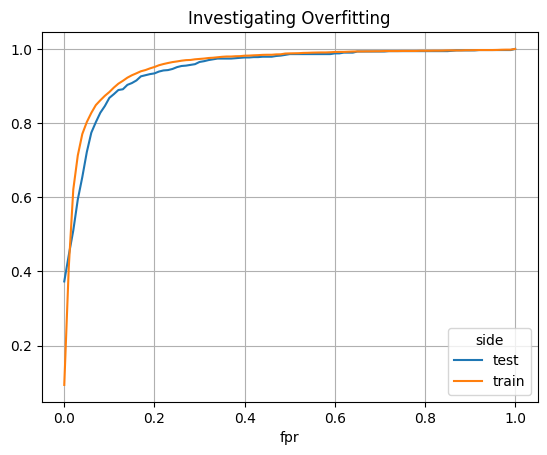

In [54]:
# ROCS in one line
# let's compare training and testing performance 
_=scores["rankings"]["roc_curves"].groupby(["side",'fpr']).mean().mean(axis=1).unstack().T.plot(grid=True,title="Investigating Overfitting")

# similarly to scores, in rocs you will find FPR and TPR for each crossvalidation fold.

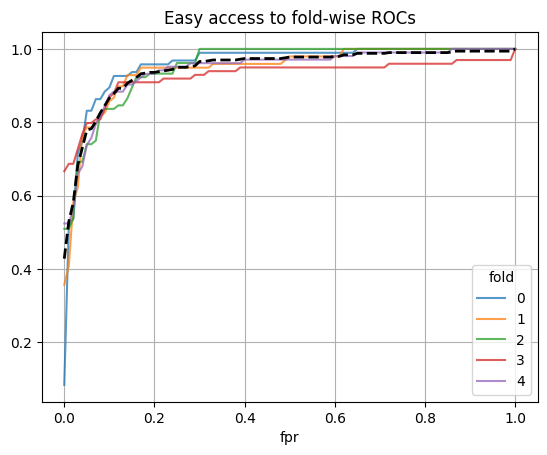

In [55]:
# in rocs you can eaily compute ROC for each fold to assess the stability of trained models.
ax = scores["rankings"]["roc_curves"].query("side=='test'").reset_index().set_index(["fold","fpr"])[1].unstack().T.plot(title = 'Easy access to fold-wise ROCs', alpha = .75)
_ = scores["rankings"]["roc_curves"].query("side=='test'").groupby('fpr').mean()[1].plot(ax = ax, color = 'k', lw = 2, ls = '--',grid=True)

# the black dotted line is the average ROC across folds 